In [10]:
####
# WHEN : APRIL 14,2020
#
# WHAT : B)CHART&MARX-AUTOMATE-ONE.ipynb
#
# HOW : It iterates through one by one of Chandra's Obsid
#       You must have already chandra repro that Obsid before you try this
#       What this notebook does is a few steps :
#            0) You open the repro files, find contaminated region
#       
#            1) You then you save the region and the background to look at
#
#            2) And then put together and event file: reg + bkg - contam
#
#            2) Then it prepares the ray-trace file, which is ran with the 
#               event file with contamination blocked out, which you have to
#               run at http://cxc.harvard.edu/ciao/PSFs/chart2/runchart.html
#               
#            3) Once you have traced the ray properly, you are ready to run
#               Marx, which basically simulates the ray for you. 
#               It also cleans up the effects due to pile up. 
#
#            4) And then, the simulated marx rays is yet another region you have
#               to open and look inside, to get region + bkg
#               DON'T WORRY, THERE'S NO MORE CONTAMINATION AT THIS POINT 
# 
# INPUT : You must have already chandra repro that Obsid before you try this
#                str(Obsid+'/repro/acisf'+ObsidZero+'_repro_evt2.fits')
#         You must have determined pair of high and low flux OBSID to look at
#                LIST
#         Let us just tell you from the get-go if we want soft or hard photons
#               IsItSoft = str(("yes") )
#         You also input the fk.reg files that you have already created in A) 
#
# OUTPUT : How much radius to look at (determined manually)
#              RLIST    
#          &
#          You also get to save the contaminated files here
#              str(Obsid+"_contam.reg") , which we will rewrite as : 
#                 -> str(Obsid+"_soft_exclude_contam_"+radius+".reg")
#                 -> str(Obsid+"_exclude_contam_"+radius+".reg")
#          & 
#          The region + bkground to look at are the following :
#                SRCREG = str(Obsid+"_soft_exclude_"+str(RADIUS)+".reg")
#                BKGREG = str(Obsid+"_soft_exclude_bkg_"+str(RADIUS)+".reg")
#              or
#                SRCREG = str(Obsid+"_soft_"+str(RADIUS)+".reg")
#                BKGREG = str(Obsid+"_soft_bkg_"+str(RADIUS)+".reg")
#              or
#                SRCREG = str(Obsid+"_"+str(RADIUS)+".reg")
#                BKGREG = str(Obsid+"_bkg_"+str(RADIUS)+".reg")
#              or
#                SRCREG = str(Obsid+"_exclude_"+str(RADIUS)+".reg")
#                BKGREG = str(Obsid+"_exclude_bkg_"+str(RADIUS)+".reg")
#
#         & just a side note : 
#         The event file of region + background - contaminated is stored as the
#         ReproFile -- this is NOT saved, but can be called up anytime
#             ReproFile = ExcludePartsOfSkyInEventFile(Obsid)
#               	returnedFile = str(Obsid+"_soft_exclude_"+RADIUS+'_evt2.fits')
#               	returnedFile = str(Obsid+"_soft_"+RADIUS+'_evt2.fits')
#               	returnedFile = str(Obsid+"_exclude"+RADIUS+'_evt2.fits')
#               	returnedFile = str(Obsid+"_soft"+RADIUS+'_evt2.fits')
#
#         & 
#         then extract the damn spectrum in the region you want without contamination:
#         RunSpecExtract(Obsid,ObsidType,ObsidZero,needBKG,ReproFile,asolfile,\
#                             bPixFile,maskFile)
#               	 .rmf, .arf, .pi, grp.pi
#
#         &
#         then you get the chart files which you must run in chandra:
#         ObsidType = ComeUpWithObsidName(IsItSoft,DidYouBlockJet,Obsid,RADIUS ) 
#               	ChartName = str(ObsidType + "_source_flux_chart.dat" )
#
#        & 
#        then you get the chart files after chandra processed them  :
#             HRMA_RA_DEC_ObsidType_source_flux_chart.dat_dithered/
#               	...._source_flux_chart.dat_dithered_i0000_rays.fits 
#               	 minumum I do about 3 iterations, & should ave them
#        &
#        then you get the marx files : 
#               	...._source_flux_chart.dat_dithered_i0000.dir/*.dat
#            And without pileup
#               	...._source_flux_chart.dat_dithered_i0000.dir/pileup/*.dat
#        &
#        then you get the .psf & *proj.fits files :
#               	....this is the same as marx, but ran with simulate_psf
#        & 
#        FINALLY, you get *image.fits files :
#               	.... this is it! This it the one you want !
#                   It will have any contamination blocked out. 
#
#
############################################################################

In [11]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import Angle
from astropy.io import fits
import math
#from Library import *
import os
import sys
import re
plt.rcParams['figure.figsize']=(18,18)
%matplotlib inline
print(os.getcwd())

/Users/tzegoh/Desktop/ciao


In [12]:
# Sherpa specific 
from sherpa_contrib.all import *
from sherpa import *
from ciao_contrib.runtool import *

from ciao_contrib.runtool import acis_process_events, dmstat, dmmerge
import ciao_contrib.runtool
import ciao_contrib.runtool as rt
import sherpa.astro.ui as ui
from sherpa_contrib.profiles import *
from six.moves.configparser import *
from sherpa.astro.ui import *
# Chips
#import chips_contrib.utils
#from chips_contrib.utils import *
#from chips_contrib import *
#from pychips import *
#from pychips.hlui import *
#from pycrates import *

# Marx
from sherpa_contrib.marx import *
# ChaRT
from sherpa_contrib.chart import *

# DS9
import subprocess
import glob
from glob import glob

from paramio import *
import paramio

In [13]:
'''If you are re-running for hard or soft photons, just run it from this point '''
# Honestly, just set this to "no" , or "yes", every single run through. This way,
# It is easy to see later on if there is an effect from hard X-ray of no 

IsItSoft = str(("yes") )

In [14]:
# Basically 2 threads that you want to look at relating to this notebook 
'''http://cxc.harvard.edu/ciao/PSFs/chart2/'''
'''http://cxc.harvard.edu/ciao/threads/marx/#opps'''

'http://cxc.harvard.edu/ciao/threads/marx/#opps'

In [58]:
def AddZerosToObsid(Obsid):
    ''' OK, this will turn add zeros in front of the Observation ID.'''
    if len(Obsid)==1:
        Obsid = str('0000'+Obsid)
    elif len(Obsid)==2:
        Obsid = str('000'+Obsid) 
    elif len(Obsid)==3:
        Obsid = str('00'+Obsid)
    elif len(Obsid)==4:
        Obsid = str('0'+Obsid)
    return Obsid
    
def SoftOrRegular(ObsidType):
    ''' This will tell you whether you get soft or regular photons.'''
    
    if 'soft' in ObsidType:
        print('it is soft photons')
        # When you chart later, you decide if you want regular or soft. 
        LowKev = 0.3 # Use O.4 for regular ; 0.3 for soft
        HiKev = 2.0    # Use 6 for regular ; 2.0 for soft 
    else: 
        print('it is hard photons')
        LowKev = 0.4 # Use O.4 for regular ; 0.3 for soft
        HiKev = 6.0    # Use 6 for regular ; 2.0 for soft  
    return (LowKev,HiKev)
        
def ComeUpWithObsidName(IsItSoft,DidYouBlockJet,Obsid,radius):
    ''' This comes up for you the appropriate naming of the files : Important if
         you want to seperate out all the different types of analysis'''
    IsItSoft = str(IsItSoft)
    DidYouBlockJet = str(DidYouBlockJet)
    Obsid = str(Obsid)
    RADIUS = str(radius)
    
    #SOFT
    if IsItSoft == 'yes':
        if DidYouBlockJet == 'yes':
            ObsidType = str(Obsid +"_soft_exclude_"+RADIUS)
        else:
            ObsidType = str(Obsid +"_soft_"+RADIUS)
            
    #REGULAR   
    else:
        if DidYouBlockJet == 'yes':
            ObsidType = str(Obsid +"_exclude_"+RADIUS)
        else:
            ObsidType = str(Obsid+"_"+RADIUS )
    return(ObsidType)

def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    
    return (sorted(data, key=alphanum_key))


def GiveMeRaAndDec(fkName):
    '''This will give you the RA and Dec. This is in units of 
     Right Ascension:  hours ;  minutes ;  seconds
     Declination:  degrees ; arcminutes ; arcseconds'''
    f= open(fkName,"r")
    for lines in f:
        #print(lines)
        linesSplit = re.split('[,()]',lines)
        #print(linesSplit,'linesSplit')
        RA,DEC = linesSplit[1],linesSplit[2]
        break # you only want the first one
    f.close()
    return(RA,DEC)

def ExcludePartsOfSkyInEventFile(IsItSoft,DidYouBlockJet,Obsid,ObsidZero,radius):
    ''' This comes up for you the appropriate naming of the files : Important if
         you want to seperate out all the different types of analysis.
         THIS IS ONLY FOR THE NAMING FOR CREATING IMAGE.FITS FILES. 
         '''
    IsItSoft = str(IsItSoft)
    DidYouBlockJet = str(DidYouBlockJet)
    Obsid = str(Obsid)
    Original_Loc= str(Obsid+'/repro/acisf'+ObsidZero+'_repro_evt2.fits')
    RADIUS = str(radius)
    dmcopy.punlearn()
    
    #SOFT
    if IsItSoft == 'yes':
        if DidYouBlockJet == 'yes':
            dmcopy(str(Original_Loc+'[exclude sky=region('+Obsid+'_soft_exclude_'\
                       +RADIUS+'_contam.reg)]'),
                   outfile=str(Obsid+"_soft_exclude_"+RADIUS+'_evt2.fits'),
                   clobber=True)
            returnedFile = str(Obsid+"_soft_exclude_"+RADIUS+'_evt2.fits')
        else:
            #dmcopy(str(Original_Loc+'[exclude sky=region('+Obsid+'_soft.reg)]'),
            dmcopy(str(Original_Loc),
                   outfile=str(Obsid+"_soft_"+RADIUS+'_evt2.fits'),
                   clobber=True)
            returnedFile = str(Obsid+"_soft_"+RADIUS+'_evt2.fits')
            
    #REGULAR ie HARD  
    else:
        if DidYouBlockJet == 'yes':
            dmcopy(str(Original_Loc+'[exclude sky=region('+Obsid+'_exclude_'\
                       +RADIUS+'_contam.reg)]'),
                   outfile=str(Obsid+"_exclude"+RADIUS+'_evt2.fits'),
                   clobber=True) 
            returnedFile = str(Obsid+"_exclude"+RADIUS+'_evt2.fits')
            
        else:
            #dmcopy(str(Original_Loc+'[exclude sky=region('+Obsid+'_soft.reg)]'),
            dmcopy(str(Original_Loc),
                   outfile=str(Obsid+"_soft"+RADIUS+'_evt2.fits'),
                   clobber=True)
            returnedFile = str(Obsid+"_soft"+RADIUS+'_evt2.fits')
            
    # REF, DO NOT USE : 
    #dmcopy "1595/repro/acisf01595_repro_evt2.fits[bin x=::1,y=::1]" 1595_image.fits
    # THIS CODE IS JUST GOOD FOR CREATING IMAGE.FITS FILES
    print(returnedFile,', This is the file that you can use from now on .')
    return(returnedFile)

def RunSpecExtract(Obsid,ObsidType,ObsidZero,needBKG,ReproFile,asolfile,bPixFile,maskFile):
    ''' This runs specextract for you, and gets the spectrum.
        This is important coz you need the pi filr '''
    ardlib.punlearn()
    specextract.punlearn()

    INfile = str(ReproFile+'[sky=region('+ObsidType+'.reg)]')
    BKGfile = str(ReproFile+'[sky=region('+ObsidType+'_bkg.reg)]')
    #INfile = str(Obsid+'/repro/acisf'+
    #             ObsidZero+'_repro_evt2.fits[sky=region('+
    #             ObsidType+'.reg)]')
    #BKGfile = str(Obsid+'/repro/acisf'+
    #             ObsidZero+'_repro_evt2.fits[sky=region('+
    #             ObsidType+'_bkg.reg)]')
    
    if needBKG == 'yes': 
        ReadOut = specextract(infile=INfile,
                outroot=ObsidType,
                bkgfile=BKGfile,
                asp=asolfile,
                badpixfile=bPixFile,
                mskfile= maskFile,
                clobber='True', weight='no',verbose=2
                )
    else:
        ReadOut = specextract(infile=INfile,
                outroot=ObsidType,
                asp=asolfile,
                badpixfile=bPixFile,
                mskfile= maskFile,
                clobber='True', weight='no',verbose=2
                )
    print('We ran spectxtract !')
    return(ReadOut)   

def GiveMeNominalPositions(Header):
    '''This will give you the nominal positions of RA, ROLL AND DEC '''
    lines = Header.splitlines()
    for i in range(len(lines)):
        if '_NOM' in lines[i]:
            print(lines[i])
            if 'RA_NOM' in lines[i]:
                items=lines[i].split()
                RA_NOM =items[2]
                print('RA_NOM',RA_NOM)
            if 'DEC_NOM' in lines[i]:
                items=lines[i].split()
                DEC_NOM =items[2]
                print('DEC_NOM',DEC_NOM)
            if 'ROLL_NOM' in lines[i]:
                items=lines[i].split()
                ROLL_NOM =items[2]
                print('ROLL_NOM',ROLL_NOM)
    return(RA_NOM,DEC_NOM,ROLL_NOM)
 
def GiveMeSourcePositions(Header):
    '''This will give you the nominal positions of RA, ROLL AND DEC '''
    lines = Header.splitlines()
    for i in range(len(lines)):
        if 'SRC_' in lines[i]:
            if 'SRC_RA' in lines[i]:
                print(lines[i])
                items=lines[i].split()
                SRC_RA =items[2]
                print('SRC_RA',SRC_RA)
            if 'SRC_DEC' in lines[i]:
                print(lines[i])
                items=lines[i].split()
                SRC_DEC =items[2]
                print('SRC_DEC',SRC_DEC)

    return(SRC_RA,SRC_DEC)


def GiveMeOffSet(DETECTOR,SIM_X,SIM_Y,SIM_Z):
    '''This will calculate the offset for you in x,y,z'''
    OffSet = np.array([['ACIS-I',-0.78234819833843,0,-233.5924630914],
    ['ACIS-S',-0.68426746699586,0,-190.1325231040],
    ['HRC-I',-1.0402925884,0,126.9854943053],
    ['HRC-S(spec)',-1.4295857921,0,250.4559758190],
    ['HRC-S(image)',-1.5333365632,0,250.4559758190]], dtype=object)

    for i in range(OffSet.shape[0]):
        print(OffSet[i])
        if OffSet[i,0]==DETECTOR:
            print('YAS')
            OffsetX = float(SIM_X) - OffSet[i,1]
            OffsetY = float(SIM_Y) - OffSet[i,2]
            OffsetZ = float(SIM_Z) - OffSet[i,3]
    return(OffsetX,OffsetY,OffsetZ)

def GiveMeBlur(DETECTOR):
    BLUR =0
    '''This will give you the blurring effects '''
    Blur = np.array([
        ['ACIS-I',0.20],
        ['ACIS-S',0.25],
        ['HRC-I',0.07]], dtype=object)

    for i in range(Blur.shape[0]):
        print(Blur[i])
        if DETECTOR in Blur[i,0]:
            print('YAS')
            BLUR = Blur[i,1]
            print(BLUR)
            
    return(BLUR)            
            

def WasTheRegContanminated(Obsid):
    ''' This should just '''
    filename = str(Obsid+"_contam.reg")

    # If you try to open a contaminated file and it works, that means the Obsid
    # has some contamination you wanna remove. 
    try:
        f= open(filename,"r+")
        f.close()
        RETURN = str('yes')
    except:
        
        RETURN = str('no')
    return RETURN


def GiveMeACIS(Obsid):
    ACIS =0
    '''This will give you the ACIS; 
    just give the Observation ID -- this must be a string '
    ...THIS DOES NOT REALLY WORK !! KEEP AS REF '''
    Observations=find_chandra_obsid(Obsid)
    linesSplit = re.split('\n',Observations)
    #print(linesSplit)
    for items in linesSplit:
        itemsSplit = items.split()
        #print(itemsSplit)
        if itemsSplit[0] == Obsid:
            print(itemsSplit)
            ACIS = itemsSplit[2]
    return(ACIS)


def GiveMeDetector(Ra,Dec,Obs_id):
    '''You provide the RA, DEC in FK units, and the Obs ID, and this should
    tell you what detector it is being used to obtain these things.'''
    RA = str(Ra)
    DEC = str(Dec)
    Obsid = str(Obs_id)
    Observation = find_chandra_obsid(RA,DEC)
    linesSplit = re.split('\n',Observation)
    print(*linesSplit,sep='\n')
    print('\n')
    for i in range(1,len(linesSplit)):
        line = re.split('\s+',linesSplit[i])
        obsid = line[0]
        if int(obsid) == int(Obsid):
            print(line)
            detector = line[2]
            break
            
    print(obsid,detector)
    return detector



def GiveMeChartName(ObsidType,fileNo):
    '''You just give this the marx name and it will tell you when you Chart rays are '''
    
    #FK Units: Just check it against the file from part A) 
    filename = str(Obsid+"_fk.reg")
    f= open(filename,"r+")
    for lines in f:
        words = lines
    f.close()
    print(words)  
    
    # OK, this is the ra and dec of the brightest pixel 
    things = words.split(",")
    #print(things[0])
    ra_FK = str(things[0].split("(")[1])
    print(ra_FK)
    dec_FK = str(things[1])
    print(dec_FK)
    
    FolderName = str('HRMA*'+ObsidType+'_source_flux_chart.dat_dithered')
    Folder = glob(FolderName)
    print(Folder,'Folder')
    

    Path = Folder[0] # The first item 
    print(os.listdir(Path),'os.listdir(Path)')
    
    sortedPath = sorted_aphanumeric((os.listdir(Path)))
    ChooseOneFile = sortedPath[fileNo] # the first item
    #print(ChooseOneFile,'ChooseOneFile')
    ChartNamePostFix = ChooseOneFile.split('dithered')[1]
    #print(ChartNamePostFix,'ChartNamePostFix')
    Chart = str(Path+'/'+ ChooseOneFile)
    return Chart,ChartNamePostFix

In [ ]:
'''START HERE IF YOU ONLY KNOW A PAIR OF HIGH AND LOW FLUX, BUT HAVE YET TO EVEN
LOOK AT THE OTHER OBSERVASTIONS TO SEE WHAT THE BEST RADIUS TO USE IS '''

In [ ]:
ObsidLIST = (2310,2311,2418,362,12076,12077,12078,12079,12080,12081,12082,12083,\
               12084,12085,12086,12087,6831,6832,6833,6834,6835,6836,6837,6838,6839,\
               6840,11534,11535,11536,11537,11538,11539,12831,12832,13191,13195,13960,\
               13961,14513,14514,14515,14516,14517,14518,16316,16317,19638,19639,19640,\
               19641,2241,3957,3158,12794,14212,14213,14214,20603,1662,5244,4089,819,\
               3436,907,5776,2209,2130,5627,2179,2126,377)

In [34]:
''' YOU NEED TO ACTUALLY LOOK INSIDE EACH FILE !!!!! 
You should just check it quasar by quasar. At this step, even though you already know
the higehst and lowest flux, you really wanna decide:
    1)if these allow you sufficient radius ie 100" == 200 physicals to fit. 
    2)Record down manually the radii of each pair that you want to work with 
    
If it doesn't , don't choose it ; just delete and move on. There's no point in fitting
small radii.
'''

# You should have ranked the highest to lowest flux BY HAND of each observation by now
# Now, you go into each quasar, and you choose the highest vs lowest flux, and taken into
# account the region in each. You really want to have at least 100 arcsecond == 200 pixelw
# Otherwise move to either the 2nd highest flux or 2nd lowerst flux, and then keep going 
# from there
observationLIST = [9398,9845,9846,9848]
#[47,62,69,70,71,1269] 

for i in observationLIST:
    print(i)
    # Insert your Observation ID here 
    Obsid = str(i)

    # We name it very early on, so that there is no confusion 
    ObsidZero = AddZerosToObsid(Obsid)

    # EXAMPLE ds9 1595/repro/acisf01595_repro_evt2.fits
    runThisFile = str(Obsid + '/repro/acisf'+ObsidZero+'_repro_evt2.fits')
    print(runThisFile)

    # Here it is, we are running ds9: You should at least open it ONCE !!!!!
    # AT LEAST TAKE A LOOK AT IT, and confirm that there isn't any jets there or something
    subprocess.Popen(["ds9", runThisFile])
    
    print('\n')

9398
9398/repro/acisf09398_repro_evt2.fits


9845
9845/repro/acisf09845_repro_evt2.fits


9846
9846/repro/acisf09846_repro_evt2.fits


9848
9848/repro/acisf09848_repro_evt2.fits




In [ ]:
#S

In [ ]:
#T

In [ ]:
#O

In [ ]:
#P

In [1]:
''' Now, we know which pair of highest and lowest flux to look at, as well as which pair
would have the most sufficient radius for you. So, now you will:
    1) Select the pair of highest vs lowest, weighted by radii >=100"== 200 pixels

This allows you the best pair  '''
# just enter the chandra id that you want to look at
# This is the full list from part A), and it will be the first time that you have
# actually opened the repro files to take a look inside them

# So, you will end up changing/shortening this list further down 
LIST = (#1631,12801, #200"
        #7757,363 , #100"
        #4659,4660, 
        1595,18700, #180", 120" 
        #62,1269,
        1599,9398, #240", 180" 
        #362,12082,
        #12831,13191,
         #12794,20603,
        #2130,5627
        #2241 # 220" 
       )

In [2]:
# Here is the full LIST of Obsid that you want to work with
print(LIST)
# Please choose from this a pair of high and low flux 

(1595, 18700, 1599, 9398)


In [3]:
pairLISTING = []
for i in range(int(len(LIST)/2)):
    #print(LIST[2*i],LIST[(2*i)+1])
    pairLISTING.append((LIST[2*i],LIST[(2*i)+1]))
print(pairLISTING)

[(1595, 18700), (1599, 9398)]


In [4]:
#S

In [5]:
#T

In [6]:
#O

In [7]:
#P

In [8]:
'''START HERE IF YOU KNOW WHICH PAIR OF FLUXES TO USE, WHICH RADIUS TO USE, AND 
WANT TO BOX CONTAMINATED REGION UP '''

'START HERE IF YOU KNOW WHICH PAIR OF FLUXES TO USE, WHICH RADIUS TO USE, AND \nWANT TO BOX CONTAMINATED REGION UP '

In [17]:
''' YOU NEED TO ACTUALLY LOOK VERY VERY CAREFULLY INSIDE EACH FILE !!!!! 
Find out : 
    1)If there is a jet or not, that is it !!!! 
        1a) If there is , SAVE : Obsid_contam.reg
    2) how much radius you actually need around each 
    3) Record down manually what radius is needed for each pair if you haven't done it
    
    Remember that the radius has to be the same around each pair '''

# It's a bit easier if you just look at pairs of high & low flux 
# Honestly, just enter it two at a time -- IT'S BETTER TO DO THIS BY HAND 
pairLIST = [1599,9398] 

for i in pairLIST:
    print(i)
    # Insert your Observation ID here 
    Obsid = str(i)
    
    #FK Units :You already hace this file from A) Now just check that the numbers match. 
    filename = str(Obsid+"_fk.reg")
    f= open(filename,"r+")
    for lines in f:
        words = lines
    f.close()
    print(words)

    # We name it very early on, so that there is no confusion 
    ObsidZero = AddZerosToObsid(Obsid)

    # EXAMPLE ds9 1595/repro/acisf01595_repro_evt2.fits
    runThisFile = str(Obsid + '/repro/acisf'+ObsidZero+'_repro_evt2.fits')
    print(runThisFile)

    # Here it is, we are running ds9: You should at least open it ONCE !!!!!
    # AT LEAST TAKE A LOOK AT IT, and confirm that there isn't any jets there or something
    subprocess.Popen(["ds9", runThisFile])
    
    print('\n')

'''
HERE IS WHAT YOU ARE LOOKING TO SAVE !!!!!!!
-----------------------------------------------------------
3) THE CONTAMINATED REGION : only if there is something you want to block out
# you just add another postfix, after the ones below , of _contam.reg
# you do not need to add anymore postfix, just use the ones below 
SAVE : Obsid_contam.reg


'''

1599
circle(18:21:57.211,+64:20:36.21,0.6666666666666666')
1599/repro/acisf01599_repro_evt2.fits


9398
circle(18:21:57.204,+64:20:36.08,0.6666666666666666')
9398/repro/acisf09398_repro_evt2.fits




'\nHERE IS WHAT YOU ARE LOOKING TO SAVE !!!!!!!\n-----------------------------------------------------------\n3) THE CONTAMINATED REGION : only if there is something you want to block out\n# you just add another postfix, after the ones below , of _contam.reg\n# you do not need to add anymore postfix, just use the ones below \nSAVE : Obsid_contam.reg\n\n\n'

In [ ]:
#S

In [ ]:
#T

In [ ]:
#O

In [ ]:
#P

In [ ]:
''' START HERE IF YOU KNOW WHICH PAIR OF FLUXES YOU WANT, AND YOU KNOW THE RADIUS YOU
WANT TO USE, AND YOU HAVE ALREADY SAVED THE CONTAMINATED REGION '''

In [18]:
# HERE IS THE VERY FINAL LIST -- put this in by hand

# At this point, you would have an amended list, based on what you fixed before.
LIST = (#1631,12801,7757,10730,4659,4660,1595,18700,\
        #62,1269,1599,2186,362,12082,12831,13191,\
        #12794,20603
        1595,18700,
        1599,9398
        )


# You need to find out how much radius to include put around each pair 
RLIST= (#200,200,60,60,120,120,120,120,\
       #35,35,60,60,50,50,100,100,\
       #100,100
        180,120,
        240,180
        )


In [19]:
# AT LEAST TAKE A LOOK TO MAKE SURE THAT the contaminated files WORKS !!
# Note that there can be more than one box per contaminated region . 
# box : (xcenter,ycenter,width,height,angle)

for i in range(len(LIST)):
    Obsid = str(LIST[i])
    radius = str(RLIST[i])
    filename = str(Obsid+"_contam.reg")
    try:
        f= open(filename,"r+")
        print(filename)
        for lines in f:
            words = lines
            print(words)
        f.close()
        
    except:
        continue


1595_contam.reg
box(4386.875,3989,5.75,7,0)

box(4300.375,4004.875,4.75,4.25,0)

box(4158.2,4079.2,6.048,4.752,0)

box(3943.28,3953.488,4.752,5.616,0)

box(4101.205,4277.9884,9.7044905,5.9719893,0)

box(4150.847,4302.996,0,6.718464,0)

box(4064.0035,4307.5574,6.31296,4.234752,0)

box(4156.36,4305.56,0,14.4,0)

box(4063.8088,3959.9376,6.5494809,10.59764,134.99997)

box(4051.2,3942.7805,5.7599999,10.44,134.99997)

18700_contam.reg
box(4217.1124,4255.1402,8.6069079,7.4592007,0)

box(4003.6993,4131.3394,7.787325,7.1883,0)

box(4124.103,4134.6339,7.7875608,11.381707,134.99997)

box(4108.2303,4119.9582,8.3860974,14.376585,134.99997)

box(4053.2942,3934.7346,6.9331483,6.239838,0)

1599_contam.reg
box(3841.4014,4430.3591,12.96,467.99999,38.999862)

box(4373.9775,3774.7994,15.481067,507.20921,38.999862)

box(3743.4034,4418.4235,17.62294,429.4529,48.999862)

box(4457.7202,3802.519,12.96,398.87999,48.999862)

box(3839.96,4472.12,15.84,18.72,0)

box(4253.6,4338.8,-8.4,15.6,0)

box(4169.6,4268,13.2

In [20]:
''' START HERE IF YOU HAVE CONTAMINATED REGION, ALREADY BOXED IT UP, AND JUST 
NEED A NEW NAME '''

' START HERE IF YOU HAVE CONTAMINATED REGION, ALREADY BOXED IT UP, AND JUST \nNEED A NEW NAME '

In [21]:
'''THIS JUST GIVES YOU 

    1)THE CORRECT LABEL FOR THE CONTAMINATED FILES, WHICH YOU USE TO EXCLUDE OUT LATER. 
THIS PROCESS WILL AUTOMATICALLY SORT IT OUT FOR YOU. You just need to give it 
*_contam.reg

# SAVE : _soft_exclude_contam_RADIUS.reg     # for soft X-ray
    AND : _exclude_contam_RADIUS.reg         # for hard X-ray'''

for i in range(len(LIST)):
    Obsid = str(LIST[i])
    radius = str(RLIST[i])
    filename = str(Obsid+"_contam.reg")

    # If you try to open a contaminated file and it works, that means the Obsid
    # has some contamination you wanna remove. 
    try:
        f= open(filename,"r+")
        print(filename)
        for lines in f:
            words = lines
            if IsItSoft == "yes":
                newFilename = str(Obsid+"_soft_exclude_"+radius+"_contam.reg")
                print(newFilename)
                g = open(newFilename,"a+")
                g.write(words)
                g.close()
            else:
                newFilename = str(Obsid+"_exclude_"+radius+"_contam.reg")
                print(newFilename)
                g = open(newFilename,"a+")
                g.write(words)
                g.close()
                
        f.close()

    # If it fails when you try to open it, that means it has no contaminated file   
    except:
        continue


1595_contam.reg
1595_soft_exclude_180_contam.reg
1595_soft_exclude_180_contam.reg
1595_soft_exclude_180_contam.reg
1595_soft_exclude_180_contam.reg
1595_soft_exclude_180_contam.reg
1595_soft_exclude_180_contam.reg
1595_soft_exclude_180_contam.reg
1595_soft_exclude_180_contam.reg
1595_soft_exclude_180_contam.reg
1595_soft_exclude_180_contam.reg
18700_contam.reg
18700_soft_exclude_120_contam.reg
18700_soft_exclude_120_contam.reg
18700_soft_exclude_120_contam.reg
18700_soft_exclude_120_contam.reg
18700_soft_exclude_120_contam.reg
1599_contam.reg
1599_soft_exclude_240_contam.reg
1599_soft_exclude_240_contam.reg
1599_soft_exclude_240_contam.reg
1599_soft_exclude_240_contam.reg
1599_soft_exclude_240_contam.reg
1599_soft_exclude_240_contam.reg
1599_soft_exclude_240_contam.reg
1599_soft_exclude_240_contam.reg
1599_soft_exclude_240_contam.reg
9398_contam.reg
9398_soft_exclude_180_contam.reg
9398_soft_exclude_180_contam.reg
9398_soft_exclude_180_contam.reg
9398_soft_exclude_180_contam.reg
9398_s

In [22]:
'''START HERE IF YOU DO NOT HAVE CONTAMINATED RERGION, AND YOU NEED TO CREATE REGION
FILES AND BACKGROUND REGION FILES'''

'START HERE IF YOU DO NOT HAVE CONTAMINATED RERGION, AND YOU NEED TO CREATE REGION\nFILES AND BACKGROUND REGION FILES'

In [23]:
''' THIS GIVES YOU 
    1)THE CORRECT REGION TO LOOK AT, CENTRED ON THE BRIGHTEST SOURCE
        -- it is accurately named with things like "soft exclude, soft etc "

'''
# We set the radius that we want 
#RADIUS = 250 # in units of arcseconds

for i in range(len(LIST)):
    
    RADIUS = RLIST[i]
    Obsid = str(LIST[i])
    DidYouBlockJet = WasTheRegContanminated(Obsid)
    print(DidYouBlockJet,' DidYouBlockJet')
    
    # We name it very early on, so that there is no confusion 
    ObsidZero = AddZerosToObsid(Obsid)
    # OK, this is the original event file
    OriginalRepro = str(Obsid+'/repro/acisf'+ ObsidZero+'_repro_evt2.fits')
    print(OriginalRepro)
    
    # OK, at this point, you already have the the fk, reg and bkg files in fudicial radius.
    # So, open them
    
    radius_FK = str(str(float(RADIUS/60)) + '\'') # in arcminutes 
    print(radius_FK)
    radius_pix = str(RADIUS/0.492) # units in pixel
    print(radius_pix)
    annulus_pix = str((RADIUS+10)/0.492) # units in pixel for outer annulus
    print(annulus_pix)
    
    
    #FK Units: Just check it against the file from part A) 
    filename = str(Obsid+"_fk.reg")
    f= open(filename,"r+")
    for lines in f:
        words = lines
    f.close()
    print(words)  
    
    # OK, this is the ra and dec of the brightest pixel 
    things = words.split(",")
    #print(things[0])
    ra_FK = things[0].split("(")[1]
    print(ra_FK)
    dec_FK = things[1]
    print(dec_FK)
    
    #Physical Coordinates
    filename = str(Obsid+".reg")
    f= open(filename,"r+")
    for lines in f:
        words = lines
    f.close()
    
    # OK, this is the ra and dec of the brightest pixel 
    things = words.split(",")
    #print(things[0])
    ra = things[0].split("(")[1]
    print(ra)
    dec = things[1]
    print(dec)

    #FKREG  = str(ObsidType+"_fk.reg")
    SRCREG = str(ObsidType+".reg")
    BKGREG = str(ObsidType+"_bkg.reg")
                
        
    print(FKREG)
    print(SRCREG)
    print(BKGREG)
        
    # Creating the fk file 
    #filename = FKREG
    #f= open(filename,"w+")
    #words = str('circle('+  ra_FK +','+ dec_FK +','+ radius_FK +')' )
    #print(words)
    #f.write(words)
    #f.close()

    # Creating the reg file 
    filename = SRCREG
    f= open(filename,"w+")
    words = str('circle('+  ra +','+ dec +','+ radius_pix +')' )
    print(words)
    f.write(words)
    f.close()

    # Creating the bkg_reg file 
    filename = BKGREG
    f= open(filename,"w+")
    words = str('annulus('+  ra +','+ dec +','+ radius_pix +','+annulus_pix +')' )
    print(words)
    f.write(words)
    f.close()
        
        
    print("\n")
'''    
# THIS IS HOW YOU HAVE TO SAVE in DS9 
# NOTE : If not soft nor exclude, this would have been saved before already. 
# str(Obsid ) # Choose one 
# str(Obsid +"_exclude")# You block out the jet if there is any .

# SOFT
# str(Obsid +"_soft") # Choose one 
# str(Obsid +"_soft_exclude")# You block out the jet '''        

yes  DidYouBlockJet
1595/repro/acisf01595_repro_evt2.fits
3.0'
365.8536585365854
386.1788617886179
circle(0:20:25.2231,+15:40:54.676,0.32800')

0:20:25.2231
+15:40:54.676
4057.9989
3952.0003
1595_fk_180.reg
1595_soft_exclude_180.reg
1595_soft_exclude_180_bkg.reg
circle(0:20:25.2231,+15:40:54.676,3.0')
circle(4057.9989,3952.0003,365.8536585365854)
annulus(4057.9989,3952.0003,365.8536585365854,386.1788617886179)


yes  DidYouBlockJet
18700/repro/acisf18700_repro_evt2.fits
2.0'
243.90243902439025
264.2276422764228
circle(0:20:25.2806,+15:40:54.540,0.32800')

0:20:25.2806
+15:40:54.540
4116.9996
4127.9878
18700_fk_120.reg
18700_soft_exclude_120.reg
18700_soft_exclude_120_bkg.reg
circle(0:20:25.2806,+15:40:54.540,2.0')
circle(4116.9996,4127.9878,243.90243902439025)
annulus(4116.9996,4127.9878,243.90243902439025,264.2276422764228)


yes  DidYouBlockJet
1599/repro/acisf01599_repro_evt2.fits
4.0'
487.8048780487805
508.130081300813
circle(18:21:57.211,+64:20:36.21,0.6666666666666666')
18:21:57.

'    \n# THIS IS HOW YOU HAVE TO SAVE in DS9 \n# NOTE : If not soft nor exclude, this would have been saved before already. \n# str(Obsid ) # Choose one \n# str(Obsid +"_exclude")# You block out the jet if there is any .\n\n# SOFT\n# str(Obsid +"_soft") # Choose one \n# str(Obsid +"_soft_exclude")# You block out the jet '

In [24]:
#S

In [25]:
#T

In [26]:
#O

In [27]:
#P

In [28]:
''' START HERE IF YOU ALREADY HAVE THE CONTMANINATED REGIONS, THE REG AND BKG REG FILES
AND YOU ARE READY TO GET THE CHART.DAT FILES '''

' START HERE IF YOU ALREADY HAVE THE CONTMANINATED REGIONS, THE REG AND BKG REG FILES\nAND YOU ARE READY TO GET THE CHART.DAT FILES '

yes DidYouBlockJet
1595/repro/acisf01595_repro_evt2.fits
1595_soft_exclude_180_evt2.fits , This is the file that you can use from now on .
1595_soft_exclude_180_evt2.fits
pcadf108568303N003_asol1.fits ASOLFILE
acisf01595_repro_bpix1.fits Bpix
acisf01595_000N003_msk1.fits mask
We ran spectxtract !
Running specextract
Version: 11 May 2018

Running tool dmlist using:
>>> dmlist "1595_soft_exclude_180_evt2.fits[sky=region(1595_soft_exclude_180.reg)]" counts
Checking dead area file for readability...
  validating file: CALDB
Checking mask file for readability...
  validating file: 1595/repro/acisf01595_000N003_msk1.fits
Checking bad pixel file for readability...
  validating file: 1595/repro/acisf01595_repro_bpix1.fits
Checking aspect file for readability...
  validating file: 1595/repro/pcadf108568303N003_asol1.fits
Checking source file for readability...
  validating file: 1595_soft_exclude_180_evt2.fits[sky=region(1595_soft_exclude_180.reg)]
Running tool dmlist using:
>>> dmlist "1595_so

read RMF file 18700_soft_exclude_120.rmf
Dataset               = 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 7726.39
Final fit statistic   = 5977.35 at function evaluation 218
Data points           = 590
Degrees of freedom    = 587
Probability [Q-value] = 0
Reduced statistic     = 10.1829
Change in statistic   = 1749.04
   abs1.nH        0.000665442  +/- 0.137769    
   p1.gamma       0.78301      +/- 0.143136    
   p1.ampl        7.53834e-05  +/- 6.00664e-06 
Created: 18700_soft_exclude_120_source_flux_chart.dat
yes DidYouBlockJet
1599/repro/acisf01599_repro_evt2.fits
1599_soft_exclude_240_evt2.fits , This is the file that you can use from now on .
1599_soft_exclude_240_evt2.fits
pcadf098116669N003_asol1.fits ASOLFILE
acisf01599_repro_bpix1.fits Bpix
acisf01599_000N003_msk1.fits mask
We ran spectxtract !
Running specextract
Version: 11 May 2018

Running tool dmlist using:
>>> dmlist "1599_soft_exclude_240_evt2.fits[sky=region(1599_soft

read RMF file 9398_soft_exclude_180.rmf
Dataset               = 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 56887
Final fit statistic   = 39627.1 at function evaluation 170
Data points           = 1013
Degrees of freedom    = 1010
Probability [Q-value] = 0
Reduced statistic     = 39.2348
Change in statistic   = 17259.9
   abs1.nH        0            +/- 0.00346346  
   p1.gamma       1.38672      +/- 0.01364     
   p1.ampl        0.00187306   +/- 2.37271e-05 
Created: 9398_soft_exclude_180_source_flux_chart.dat


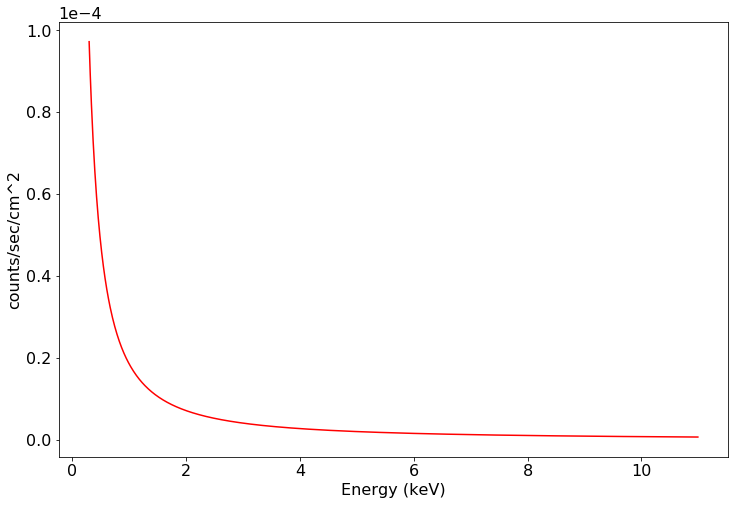

In [47]:
'''OK  now you are going to put all these into a File, with the contaminated regions
removed, and only limited to the arcseconds that you want to look at.

Furthermore, we will then run the specextract for it '''

for i in range(len(LIST)):
    
    RADIUS = int(RLIST[i])
    Obsid = str(LIST[i])
    DidYouBlockJet = WasTheRegContanminated(Obsid)
    print(DidYouBlockJet,'DidYouBlockJet')
    ObsidType = ComeUpWithObsidName(IsItSoft,DidYouBlockJet,Obsid,RADIUS )
    # We name it very early on, so that there is no confusion 
    ObsidZero = AddZerosToObsid(Obsid)
    # OK, this is the original event file
    OriginalRepro = str(Obsid+'/repro/acisf'+ ObsidZero+'_repro_evt2.fits')
    print(OriginalRepro)

    # Essentially, this Reprofile will be the event file 
    # minus away the contaminated region 
    ReproFile = ExcludePartsOfSkyInEventFile(IsItSoft,DidYouBlockJet,Obsid,ObsidZero,RADIUS)
    print(ReproFile) # we will use this much much later in place of .....image.fits

    #dmcopy(str(Original_Loc+'[exclude sky=region('+Obsid+'_soft_exclude_contam_'\
    #+RADIUS+'.reg)]'),
    #outfile=str(Obsid+"_soft_exclude_"+RADIUS+'_evt2.fits'),
    ''' Note that this REPROFILE has the contamination blocked out !!!!'''



    # NOW, YOU GET THE PHYSICAL + BACKGROUND FILE with the contaminated part excluded out !
    # You can uncover to check it
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #subprocess.Popen(["ds9", ReproFile])
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    '''4) PHYSICAL + BACKGROUND REGION blocking out the CONTAMINATED REGION 
    # THIS IS HOW YOU HAVE TO SAVE in DS9 
    # str(Obsid ) # Choose one 
    # str(Obsid +"_exclude")# You block out the jet if there is any .

    or

    # SOFT
    # str(Obsid +"_soft") # Choose one 
    # str(Obsid +"_soft_exclude")# You block out the jet 

    The REPRO-FILE ESSENTIALLY EXCLUDES THE CONTAMINATED REGION 
    -------------------------------------------------------------------------

    '''
    # RUN THE SPECTRUM 
    ASOLFILE = dmkeypar(OriginalRepro,'ASOLFILE',echo='yes') 
    print(ASOLFILE,'ASOLFILE')
    asolfile=str(Obsid+'/repro/'+ASOLFILE )
    Bpix = dmkeypar(OriginalRepro,'BPIXFILE',echo='yes') 
    print(Bpix,'Bpix')
    bPixFile = str(Obsid+'/repro/'+Bpix )
    mask = dmkeypar(OriginalRepro,'MASKFILE',echo='yes') 
    print(mask,'mask')
    maskFile = str(Obsid+'/repro/'+mask )

    needBKG = 'no' # we assume that you want a background file . Change it for 'no' if not.
    
    # NOTE THAT THIS SPECTRUM HAS THE CONTAMINATION REMOVED, and is limited to just
    # the radius you want to look at 
    Readout = RunSpecExtract(Obsid,ObsidType,ObsidZero,needBKG,ReproFile,asolfile,\
                             bPixFile,maskFile)   
    print(Readout)
    
    
    ''' OK, now we are ready to plot it out !!!!! '''
    # OK This is for loading 
    ObsidPI = str(ObsidType +".pi")# Use this one if you are blocking out 
    print(ObsidPI)
    LowKev, HiKev = SoftOrRegular(ObsidType)
    print (LowKev, HiKev )
                     
    # OK, here you enter more or less select the wavelengths you want to look at. 
    # PLOT IT OUT !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    load_data(ObsidPI)
    group_counts(10) # number of counts per bin
    # switch off notice, since you already specify the spectrum data at last line
    #notice(LowKev,HiKev) # channels, energy (keV), or wavelength (angstrom).
    set_source( xsphabs.abs1 * powlaw1d.p1)
    abs1.nh = 0.5#0.5
    guess(p1)
    fit()

    # Prepare to analyse: 1 JUST MEANS THE FIRST OBSID, which the case here 
    set_analysis(1, "energy", "rate", factor=1)
    # FACTOR OPTIONS ARE :
    #0 = counts/sec/keV (the default)
    #1 = counts/sec (with quantity="energy")
    #2 = keV counts/sec (with quantity="energy")

    # OK, now you would like to plot it in MATPLOTLIB
    %matplotlib inline
    fig, ax = plt.subplots(figsize = (12,8))

    source = get_source_plot()
    # The source file stores data in class
    xlo = source.xlo
    xhi = source.xhi
    y = source.y
    plt.plot(xlo,y,c='r')

    #plt.xscale("log")
    #plt.yscale("log")

    plt.xlabel('Energy (keV)',fontsize=16)
    plt.ylabel('counts/sec/cm^2',fontsize=16)

    ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
    ax.yaxis.offsetText.set_fontsize(16)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    saveName = (ObsidPI +'_spectrum.pdf')
    plt.savefig(saveName)

    # Save the spectrum for chart:
    # xlo, xhi, y : xlo and xhi is between LowKev and HiKev
    chartName = str(ObsidType + "_source_flux_chart.dat" )
    save_chart_spectrum(chartName, elow=LowKev, ehigh=HiKev)

In [ ]:
#S

In [ ]:
#T

In [ ]:
#O

In [ ]:
#P

In [48]:
''' At this point you have to go to chandra and run the ray trace here :

http://cxc.harvard.edu/ciao/PSFs/chart2/runchart.html

YOU HAVE TO ENTER IT M.A.N.U.A.L.L.Y. TO RUN CHART 

'''


# NOTE; YOU DO NEED THE CHART NAME AS WELL AS THE RA AND DEC OF THE BRIGHTEST PIXEL,
# SO HERE IT IS 
# You should run it for multiple iterations, but let's keep it to 3 iterations for now
for i in range(len(LIST)):
    RADIUS = RLIST[i]    
    Obsid = str(LIST[i])
    DidYouBlockJet = WasTheRegContanminated(Obsid)
    ObsidType = ComeUpWithObsidName(IsItSoft,DidYouBlockJet,Obsid,RADIUS )
    ChartName = str(ObsidType + "_source_flux_chart.dat" )
    print(ChartName)

    FKREG  = str(Obsid+"_fk_"+str(RADIUS)+".reg")        
    RA,DEC = GiveMeRaAndDec(FKREG)
    print('RA:',RA,'DEC:',DEC)
    f.close()
    print('\n')

1595_soft_exclude_180_source_flux_chart.dat
RA: 0:20:25.2231 DEC: +15:40:54.676


18700_soft_exclude_120_source_flux_chart.dat
RA: 0:20:25.2806 DEC: +15:40:54.540


1599_soft_exclude_240_source_flux_chart.dat
RA: 18:21:57.211 DEC: +64:20:36.21


9398_soft_exclude_180_source_flux_chart.dat
RA: 18:21:57.204 DEC: +64:20:36.08




In [59]:
'''Once you have the CHART ray trace from CXC, now you are ready to run MARX simulation'''
# At this point, you would have an amended list, based on what you fixed before.
LIST = (#1631,12801,7757,10730,4659,4660,1595,18700,\
        #62,1269,1599,2186,362,12082,12831,13191,\
        #12794,20603
        1595,18700,
        1599,9398
        )


# You need to find out how much radius to include put around each pair 
RLIST= (#200,200,60,60,120,120,120,120,\
       #35,35,60,60,50,50,100,100,\
       #100,100
        180,120,
        240,180
        )

In [60]:
'''
This will run the Marx simulation for you !!!!
'''

print('Let us go trace that ray !')

# OK, NOW YOU ARE READY TO RUN MARX FINALLY!!!
for i in range(len(LIST)): 
    
    ###########This whole block is the same as above ############
    print('\n')
    RADIUS = int(RLIST[i])
    Obsid = str(LIST[i])
    DidYouBlockJet = WasTheRegContanminated(Obsid)
    #print(DidYouBlockJet,'DidYouBlockJet')
    ObsidType = ComeUpWithObsidName(IsItSoft,DidYouBlockJet,Obsid,RADIUS )
    # We name it very early on, so that there is no confusion 
    ObsidZero = AddZerosToObsid(Obsid)
    
    # OK, this is the original event file
    OriginalRepro = str(Obsid+'/repro/acisf'+ ObsidZero+'_repro_evt2.fits')
    #print(OriginalRepro,'OriginalRepro')

    # Essentially, this Reprofile will be the event file 
    # minus away the contaminated region 
    ReproFile = ExcludePartsOfSkyInEventFile(IsItSoft,DidYouBlockJet,Obsid,ObsidZero,RADIUS)
    #print(ReproFile,'ReproFile') # we will use this much much later in place of .....image.fits
    
    ##############################################################
    ''' FIRST CHECK IF YOU DETECTOR IS ACIS-S ,ACIS-I OR HMRC '''
    FKREG  = str(Obsid+"_fk.reg")        
    Ra,Dec = GiveMeRaAndDec(FKREG)
    Obs_id = Obsid
    Detector = GiveMeDetector(Ra,Dec,Obs_id)  
    print(Detector,'Detector')
    print('\n')

    # Let us get the full path to where the Chart file is
    fileNo = 0 # usually it is 0 for the first 0000_rays.fits files (MANUAL)
    ChartName,ChartNamePostFix = GiveMeChartName(ObsidType,fileNo)
    print(ChartName)
    print(ChartNamePostFix)
    
    #------------------------------------------------------------------------
    '''NOW THAT YOU HAVE THE CHART FILES, FIRST LET US SIMULATE THE PSF .'''
    
    # export MY_DATA="my_export"
    #os.environ["MY_DATA"]="my_export"

    os.system("export MARX_ROOT=/Users/tzegoh/Desktop/ciao/marx/marx-5.4.0")
    os.system("export MARX_DATA_DIR=${MARX_ROOT}/share/marx/data")
    os.system("export PATH=${PATH}:${MARX_ROOT}/bin")
    os.system("export PFILES=${PFILES}:${MARX_ROOT}/share/marx/pfiles")
    
    #dmlist 1595/repro/acisf01595_repro_evt2.fits header | grep _NOM
    ''' Nominal RA, Nominal Dec,Nominal Roll'''
    Header = dmlist(ReproFile, opt='header')
    RA_NOM,DEC_NOM,ROLL_NOM = GiveMeNominalPositions(Header)


    ''' Correcting the Simulation offset  '''
    SIM_X  = dmkeypar(ReproFile,'SIM_X ',echo='yes')
    SIM_Y = dmkeypar(ReproFile,'SIM_Y',echo='yes')
    SIM_Z = dmkeypar(ReproFile,'SIM_Z',echo='yes')
    print(SIM_X,'SIM_X')
    print(SIM_Y,'SIM_Y')
    print(SIM_Z,'SIM_Z')
    
    '''Source Position'''
    Header = dmlist(ChartName,opt='header')
    #print(Header)
    SRC_RA,SRC_DEC = GiveMeSourcePositions(Header)
    #SRC_RA = dmkeypar(ChartName,'SRC_RA',echo='yes')
    #SRC_DEC = dmkeypar(ChartName,'SRC_DEC',echo='yes')
    
    '''ASOL , MSK AND BAD PIXEL File'''
    ASOLFILE = dmkeypar(ChartName,'ASOLFILE',echo='yes')
    print(ASOLFILE,'ASOLFILE')

    #"1595/repro/acisf01595_000N003_msk1.fits"
    MSKFILE = dmkeypar(ReproFile,'MASKFILE ',echo='yes')
    print(MSKFILE ,'MSKFILE ')

    #"1595/repro/acisf01595_000N003_bpix1.fits"
    BADPIXFILE = dmkeypar(OriginalRepro,'BPIXFILE',echo='yes')
    print(BADPIXFILE,'BADPIXFILE')
    
    ''' Gives you the Offset '''
    OffsetX,OffsetY,OffsetZ = GiveMeOffSet(Detector,SIM_X,SIM_Y,SIM_Z)
    print('OffsetX,OffsetY,OffsetZ')
    print(OffsetX,OffsetY,OffsetZ)
    
    ''' You need the start and end time of the observation   '''
    TSTART  = dmkeypar(ReproFile,'TSTART ',echo='yes')
    print(TSTART,'TSTART')
    
    '''Correct for blurring '''
    BLUR =GiveMeBlur(Detector) 
    print(BLUR,'BLUR')

    ''' OK, the parameters are now set . You can now run marx through 2 ways :
        1) Using simulate_psf, which is easier
        or 
        2) Using \marx, which is a bit harder
        
        For safety sake, I am doing both. '''
    
    '''This is it! Simulate those rays'''
    OUTROOT = str(ObsidType + '_chart')
    
    ReadOut = simulate_psf(infile=ReproFile , 
             outroot=OUTROOT, 
             ra= SRC_RA, 
             dec=SRC_DEC, 
             simulator='file',
             pileup = 'no',
             rayfile= ChartName,
             projector='marx',
             asolfile=str(Obsid+'/repro/'+ASOLFILE )
                     )
    print('Simulating those RAYS:',ReadOut)
    
    #------------------------------------------------------------------------
    '''NOW THAT YOU HAVE SIMULATE THE PSF, LET US RUN MARX AS ALTERNATIVE  .'''    
    
    '''And now we prepare to simulate marx '''
    os.system("cp $ /Users/tzegoh/Desktop/ciao/marx/marx-5.4.0/share/marx/pfiles/marx.par ./marx.par")
    os.system("chmod +w ./marx.par")
    
    
    ''' Let us get the marx file names correct '''
    marxOutput = str(ObsidType+'_marx_'+ChartNamePostFix.split('_')[1]+'.dir')
    print(marxOutput)
    marxOutputPile = str(ObsidType+'_marx_'+ChartNamePostFix.split('_')[1]+'.dir/pileup')
    print(marxOutputPile)
    # The following is the event file we will use 
    marxOutputFits = str(ObsidType+'_marx_'+ChartNamePostFix.split('_')[1]+'.fit')
    print(marxOutputFits)
    
    
    ''' Let us set all the parameters ready for the marx simulation '''
    pset("./marx", 'SAOSACFile',str(ChartName))
    os.system("pget ./marx SAOSACFile")

    pset("./marx", 'SourceType',str('SAOSAC'))
    os.system("pget ./marx SourceType")

    pset("./marx", 'OutputDir',str(marxOutput) )
    os.system("pget ./marx OutputDir")

    ##############################################

    pset("./marx", 'SourceRA',str(SRC_RA))
    os.system("pget ./marx SourceRA")

    pset("./marx", 'SourceDEC',str(SRC_DEC))
    os.system("pget ./marx SourceDEC")

    pset("./marx", 'TStart',str(TSTART))
    os.system("pget ./marx TStart")

    ##############################################

    pset("./marx", 'RA_Nom',str(RA_NOM))
    os.system("pget ./marx RA_Nom")

    pset("./marx", 'Dec_Nom',str(DEC_NOM))
    os.system("pget ./marx Dec_Nom")

    pset("./marx", 'Roll_Nom',str(ROLL_NOM ))
    os.system("pget ./marx Roll_Nom")

    ##############################################

    pset("./marx", 'DetOffsetX',str(OffsetX))
    os.system("pget ./marx DetOffsetX")

    pset("./marx", 'DetOffsetY',str(OffsetY))
    os.system("pget ./marx DetOffsetY")

    pset("./marx", 'DetOffsetZ',str(OffsetZ))
    os.system("pget ./marx DetOffsetZ")

    ##############################################

    pset("./marx", 'DetectorType',str(Detector))
    os.system("pget ./marx DetectorType")

    pset("./marx", 'GratingType',str('NONE'))
    os.system("pget ./marx GratingType")

    pset("./marx", 'ExposureTime',str(0.0))
    os.system("pget ./marx ExposureTime")

    ##############################################

    pset("./marx", 'DitherModel',str('FILE'))
    os.system("pget ./marx DitherModel")

    pset("./marx", 'AspectBlur',str(BLUR))
    os.system("pget ./marx AspectBlur")

    pset("./marx", 'DitherFile',str(Obsid+'/repro/'+ASOLFILE))
    os.system("pget ./marx DitherFile")
    
    ''' SIMULATE MARX'''
    os.system("marx @@./marx.par")
    #Check your terminal to see if it went well 
    
    '''Preparing the event files'''
    #print(marxOutput)
    #print(marxOutputFits)
    os.system('ls %s' % marxOutput)
    os.system('ls %s' % marxOutputFits)
    os.system( 'ls %s %s' % (marxOutput,marxOutputFits)   )
    
    ''' Creating an event file '''
    #marx2fits --pixadj=EDSER 1595_soft_exclude_marx_output_i0000.dir 1595_soft_exclude_marx_output_i0000.fits
    os.system( 'marx2fits --pixadj=EDSER %s %s' % (marxOutput,marxOutputFits)   )
    
    '''Create the event files with the pile up  '''
    os.system(" cp ~/Desktop/ciao/marx/marx-5.4.0/share/marx/pfiles/marxpileup.par .  " )
    os.system(" marxpileup MarxOutputDir=%s " % marxOutput)
    os.system("marx2fits --pixadj=EDSER --pileup %s %s " % (marxOutputPile,marxOutputFits) )
    
    ''' AT THIS POINT, YOU ARE DONE !!!!'''
    
    print('\n')

Let us go trace that ray !


1595_soft_exclude_180_evt2.fits , This is the file that you can use from now on .
# obsid  sepn   inst grat   time    obsdate piname target
1595      0.0 ACIS-S NONE   19.9 2001-06-10 Fabian    3C9
17088     0.0 ACIS-S NONE   33.8 2015-11-02  Meyer "3c 9"
18700     0.0 ACIS-S NONE   19.5 2015-11-03  Meyer "3c 9"
18701     0.0 ACIS-S NONE   29.3 2015-11-04  Meyer "3c 9"


['1595', '0.0', 'ACIS-S', 'NONE', '19.9', '2001-06-10', 'Fabian', '3C9']
1595 ACIS-S
ACIS-S Detector


circle(0:20:25.2231,+15:40:54.676,0.32800')

0:20:25.2231
+15:40:54.676
['HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered'] Folder
['HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0001_rays.fits', 'HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0000_rays.fits', 'HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0002_rays.fits'] os.listdir(Path)
HRMA_ra5.10510_d

acisf01599_000N003_msk1.fits MSKFILE 
acisf01599_repro_bpix1.fits BADPIXFILE
['ACIS-I' -0.78234819833843 0 -233.5924630914]
['ACIS-S' -0.68426746699586 0 -190.132523104]
YAS
['HRC-I' -1.0402925884 0 126.9854943053]
['HRC-S(spec)' -1.4295857921 0 250.455975819]
['HRC-S(image)' -1.5333365632 0 250.455975819]
OffsetX,OffsetY,OffsetZ
0.0014449422646700683 0.0 3.0071211007000045
98116135.29529 TSTART
['ACIS-I' 0.2]
['ACIS-S' 0.25]
YAS
0.25
['HRC-I' 0.07]
0.25 BLUR
Simulating those RAYS: simulate_psf
          infile = 1599_soft_exclude_240_evt2.fits
         outroot = 1599_soft_exclude_240_chart
              ra = 275.4883791666667
             dec = 64.34339166666666
    spectrumfile = 
      monoenergy = INDEF
            flux = INDEF
       simulator = file
         rayfile = HRMA_ra275.48838_dec64.34339_1599_soft_exclude_240_source_flux_chart.dat_dithered/HRMA_ra275.48838_dec64.34339_1599_soft_exclude_240_source_flux_chart.dat_dithered_i0000_rays.fits
       projector = marx
     random

In [52]:
#S

In [53]:
#T

In [54]:
#O

In [182]:
#P

In [ ]:
'''After running the marx sim, but before creating regions, at least 
take a  look at the image you created.'''

In [67]:
''' Tadah, now let us look at the simulated image ,
    1) Choose either to look at :
            simulated_psf 
            or
            marx image
    2) If there is still things to be blocked, save it as Obsid_marx_contam.reg '''

# OK, at least images and decide which ones are OK to use !!!
for i in range(len(LIST)): 
    
    ###########This whole block is the same as above ############
    print('\n')
    RADIUS = int(RLIST[i])
    Obsid = str(LIST[i])
    DidYouBlockJet = WasTheRegContanminated(Obsid)
    #print(DidYouBlockJet,'DidYouBlockJet')
    ObsidType = ComeUpWithObsidName(IsItSoft,DidYouBlockJet,Obsid,RADIUS )
    # We name it very early on, so that there is no confusion 
    ObsidZero = AddZerosToObsid(Obsid)
    
    # OK, this is the original event file
    OriginalRepro = str(Obsid+'/repro/acisf'+ ObsidZero+'_repro_evt2.fits')
    print(OriginalRepro,'OriginalRepro')

    # Essentially, this Reprofile will be the event file 
    # minus away the contaminated region 
    ReproFile = ExcludePartsOfSkyInEventFile(IsItSoft,DidYouBlockJet,Obsid,ObsidZero,RADIUS)
    #print(ReproFile,'ReproFile') # we will use this much much later in place of .....image.fits
    
    ''' OK, you need to know that centre of the brightest spot + '''
    
    ##############################################################

    # Let us get the full path to where the Chart file is
    fileNo = 0 # usually it is 0 for the first 0000_rays.fits files (MANUAL)
    ChartName,ChartNamePostFix = GiveMeChartName(ObsidType,fileNo)


    # The following is the event file we will use 
    marxOutputFits = str(ObsidType+'_marx_'+ChartNamePostFix.split('_')[1]+'.fit')
    print(marxOutputFits,'marxOutputFits')

    # Check the FK RA & DEC THAT YOU WANT 
    FKREG  = str(Obsid+"_fk.reg")        
    Ra,Dec = GiveMeRaAndDec(FKREG)
    print(Ra,'Ra',Dec,'Dec','FK Units ')
    
    REG  = str(ObsidType+".reg")        
    Ra,Dec = GiveMeRaAndDec(REG)
    print(Ra,'Ra',Dec,'Dec','Physical Units ')
    
    
    ObsidTypePSF = str(ObsidType+'_chart_projrays')
    print(ObsidTypePSF,'ObsidTypePSF')
    PsfOutputFits = str(ObsidTypePSF+'.fits')
    
    # Here it is, we are running ds9 : Choose one : psf or marx
    '''Created with %%marx '''
    subprocess.Popen(["ds9", marxOutputFits]) 
    # OR 
    '''Created with simulatedPSF'''
    #subprocess.Popen(["ds9", PsfOutputFits])
    
'''If there is still things to be blocked, save it as Obsid_marx_contam.reg'''



1595/repro/acisf01595_repro_evt2.fits OriginalRepro
1595_soft_exclude_180_evt2.fits , This is the file that you can use from now on .
circle(0:20:25.2231,+15:40:54.676,0.32800')

0:20:25.2231
+15:40:54.676
['HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered'] Folder
['HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0001_rays.fits', 'HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0000_rays.fits', 'HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0002_rays.fits'] os.listdir(Path)
1595_soft_exclude_180_marx_i0000.fit marxOutputFits
0:20:25.2231 Ra +15:40:54.676 Dec FK Units 
4057.9989 Ra 3952.0003 Dec Physical Units 
1595_soft_exclude_180_chart_projrays ObsidTypePSF


18700/repro/acisf18700_repro_evt2.fits OriginalRepro
18700_soft_exclude_120_evt2.fits , This is the file that you can use from now on .
circle(0:20:25.2806,+15:40:54.540,0.32800')

0:20:25.2806
+

In [56]:
'''After taking a look at the marx simulated image, it is now time to save the region
and the background file '''

In [69]:
'''This will just automatically save the reg and the bkg file of the marx simulated'''

# OK, at least images and decide which ones are OK to use !!!
for i in range(len(LIST)): 
    
    ###########This whole block is the same as above ############
    print('\n')
    RADIUS = int(RLIST[i])
    Obsid = str(LIST[i])
    DidYouBlockJet = WasTheRegContanminated(Obsid)
    #print(DidYouBlockJet,'DidYouBlockJet')
    ObsidType = ComeUpWithObsidName(IsItSoft,DidYouBlockJet,Obsid,RADIUS)
    # We name it very early on, so that there is no confusion 
    ObsidZero = AddZerosToObsid(Obsid)
    
    # OK, this is the original event file
    OriginalRepro = str(Obsid+'/repro/acisf'+ ObsidZero+'_repro_evt2.fits')
    print(OriginalRepro,'OriginalRepro')

    # Essentially, this Reprofile will be the event file 
    # minus away the contaminated region 
    ReproFile = ExcludePartsOfSkyInEventFile(IsItSoft,DidYouBlockJet,Obsid,ObsidZero,RADIUS)
    #print(ReproFile,'ReproFile') # we will use this much much later in place of .....image.fits

    
    ##############################################################
    ''' OK, you need to know that centre of the brightest spot + '''

    # Let us get the full path to where the Chart file is
    fileNo = 0 # usually it is 0 for the first 0000_rays.fits files (MANUAL)
    ChartName,ChartNamePostFix = GiveMeChartName(ObsidType,fileNo)


    # The following is the event file we will use 
    marxOutputFits = str(ObsidType+'_marx_'+ChartNamePostFix.split('_')[1]+'.fit')
    print(marxOutputFits,'marxOutputFits')

    # Check the RA & DEC THAT YOU WANT 
    
    REG  = str(ObsidType+".reg")        
    ra,dec = GiveMeRaAndDec(REG)
    print(ra,'Ra',dec,'Dec','Physical Units ')
    
    # Here is the source name & the background name that you want 
    radius_pix = str(RADIUS/0.492) # units in pixel
    print(radius_pix)
    annulus_pix = str((RADIUS+10)/0.492) # units in pixel for outer annulus
    print(annulus_pix)
    
    #################################################################
    # Here is the source name & the background name that you want for
    # simulate_psf instead
    
    SRCREG = str(ObsidType+"_chart_projrays.reg")
    BKGREG = str(ObsidType+"_bkg_chart_projrays.reg")      
    
    # Creating the reg file 
    filename = SRCREG
    f= open(filename,"w+")
    words = str('circle('+  ra +','+ dec +','+ radius_pix +')' )
    print(words)
    f.write(words)
    f.close()

    # Creating the bkg_reg file 
    filename = BKGREG
    f= open(filename,"w+")
    words = str('annulus('+  ra +','+ dec +','+ radius_pix +','+annulus_pix +')' )
    print(words)
    f.write(words)
    f.close()
    
    #################################################################    
    # Here is the source name & the background name that you want -- marx

        
    SRCREG = str(ObsidType+"_marx.reg")
    BKGREG = str(ObsidType+"_bkg_marx.reg")
              
    
    # Creating the reg file 
    filename = SRCREG
    f= open(filename,"w+")
    words = str('circle('+  ra +','+ dec +','+ radius_pix +')' )
    print(words)
    f.write(words)
    f.close()

    # Creating the bkg_reg file 
    filename = BKGREG
    f= open(filename,"w+")
    words = str('annulus('+  ra +','+ dec +','+ radius_pix +','+annulus_pix +')' )
    print(words)
    f.write(words)
    f.close()




1595/repro/acisf01595_repro_evt2.fits OriginalRepro
1595_soft_exclude_180_evt2.fits , This is the file that you can use from now on .
circle(0:20:25.2231,+15:40:54.676,0.32800')

0:20:25.2231
+15:40:54.676
['HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered'] Folder
['HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0001_rays.fits', 'HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0000_rays.fits', 'HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0002_rays.fits'] os.listdir(Path)
1595_soft_exclude_180_marx_i0000.fit marxOutputFits
4057.9989 Ra 3952.0003 Dec Physical Units 
365.8536585365854
386.1788617886179
circle(4057.9989,3952.0003,365.8536585365854)
annulus(4057.9989,3952.0003,365.8536585365854,386.1788617886179)
circle(4057.9989,3952.0003,365.8536585365854)
annulus(4057.9989,3952.0003,365.8536585365854,386.1788617886179)


18700/repro/acisf18700_repro_ev

In [40]:
''' OK, you created some .reg files for the MARX simulation, so now 
it is time to extract the spectrum and then you are don !!!! '''

0

In [71]:
''' OK, now you are ready to extract the spectrum in the region of the marx simulated image
 You get to choose either :
         1) Marx simulated image ie using marx @@./marx.par 
         or
         2) Using the simulated_psf '''

# OK, at least images and decide which ones are OK to use !!!
for i in range(len(LIST)): 
    
    ###########This whole block is the same as above ############
    print('\n')
    RADIUS = int(RLIST[i])
    Obsid = str(LIST[i])
    DidYouBlockJet = WasTheRegContanminated(Obsid)
    #print(DidYouBlockJet,'DidYouBlockJet')
    ObsidType = ComeUpWithObsidName(IsItSoft,DidYouBlockJet,Obsid,RADIUS )
    print(ObsidType,'ObsidType')
    # We name it very early on, so that there is no confusion 
    ObsidZero = AddZerosToObsid(Obsid)
    
    # OK, this is the original event file
    OriginalRepro = str(Obsid+'/repro/acisf'+ ObsidZero+'_repro_evt2.fits')
    print(OriginalRepro,'OriginalRepro')

    # Essentially, this Reprofile will be the event file 
    # minus away the contaminated region 
    ReproFile = ExcludePartsOfSkyInEventFile(IsItSoft,DidYouBlockJet,Obsid,ObsidZero,RADIUS)
    print(ReproFile,'ReproFile') # we will use this much much later in place of .....image.fits

    ##############################################################

    # Preparing the outroot for spectract 
    os.system("punlearn ardlib")
    os.system("punlearn specextract")


    # OK, here are the inputs 
    ObsidTypeMarx = str(ObsidType+'_marx')
    print(ObsidTypeMarx,'ObsidTypeMarx')
    #ObsidTypeMarxBkg = str(ObsidType+'_bkg_marx')
    #print(ObsidTypeMarxBkg,'ObsidTypeMarxBkg')
    

    #"1595_soft_exclude_marx_output_i0000.fits[sky=region(1595_soft_exclude_marx_bkg.reg)]", 
    #BKGFILE =  str(marxOutputFits+'[sky=region('+ObsidTypeMarxBkg+'.reg)]')  
    #print(BKGFILE)
    
    # Let us get the full path to where the Chart file is
    fileNo = 0 # usually it is 0 for the first 0000_rays.fits files (MANUAL)
    ChartName,ChartNamePostFix = GiveMeChartName(ObsidType,fileNo)
    print(ChartName)
    print(ChartNamePostFix)
    
    # The following is the event file we will use 
    marxOutputFits = str(ObsidTypeMarx+'_'+ChartNamePostFix.split('_')[1]+'.fit')
    print(marxOutputFits,'marxOutputFits')

    softEnergy = str("0.3:2:0.01")
    print(softEnergy)

    #"1595_soft_exclude_marx_output_i0000.fits[sky=region(1595_soft_exclude_marx.reg)]"
    INFILE = str(marxOutputFits+'[sky=region('+ObsidTypeMarx+'.reg)]')
    print(INFILE)
    
    BKGFILE = 0

    '''ASOL , MSK AND BAD PIXEL File'''
    ASOLFILE = dmkeypar(ChartName,'ASOLFILE',echo='yes')
    print(ASOLFILE,'ASOLFILE')

    #"1595/repro/acisf01595_000N003_msk1.fits"
    MSKFILE = dmkeypar(ReproFile,'MASKFILE ',echo='yes')
    print(MSKFILE ,'MSKFILE ')

    #"1595/repro/acisf01595_000N003_bpix1.fits"
    BADPIXFILE = dmkeypar(OriginalRepro,'BPIXFILE',echo='yes')
    print(BADPIXFILE,'BADPIXFILE')
    
    '''This is it! Extract that spectrum !!! -- > these are the .pi files '''

    ''' Alternative : using specextract on simulate_psf'''
    ObsidTypePSF = str(ObsidType+'_chart_projrays')
    print(ObsidTypePSF,'ObsidTypePSF')
    INFILE_PSF = str(ObsidTypePSF+'.fits'+'[sky=region('+ObsidTypePSF+'.reg)]')
    print(INFILE_PSF,'INFILE_PSF')

    ####################################################################     
    
    '''MARX'''    
    ReadOut = specextract(infile= INFILE,
             energy=softEnergy, # Use this for softer photons       
             outroot=ObsidTypeMarx, 
             mskfile=str(Obsid+'/repro/'+MSKFILE),
             badpixfile= str(Obsid+'/repro/'+BADPIXFILE),
             asp=str(Obsid+'/repro/'+ASOLFILE ),
             weight='no',
             verbose = 2,
             clobber='True'
                     )
    print(ReadOut)
    
    # '''Finally, we save it to a familiar format to use to radial profiles !''' 


    try:
        CONTAM = str(Obsid+'_marx_contam.reg')
        print(CONTAM)
        dmcopy(str(marxOutputFits+'[exclude sky=region('+CONTAM+')][bin sky]'), 
               str(ObsidType+'_blocked_marx_image.fits'), # THIS IS THE FINAL IMAGE/NAME TO USE
               clobber='yes') 
    except:
        dmcopy(str(marxOutputFits+'[bin x=::1,y=::1]'), 
               str(ObsidType+'_marx_image.fits'), # THIS IS THE FINAL IMAGE/NAME TO USE
               clobber='yes') 
        
    ####################################################################  
    #
    #
    # OR
    #
    #
    #
        
    #''' SIMULATE_PSF '''
    #ReadOut = specextract(infile= INFILE_PSF,
    #         energy=softEnergy, # Use this for softer photons       
    #         outroot=ObsidTypePSF, 
    #         mskfile=str(Obsid+'/repro/'+MSKFILE),
    #         badpixfile= str(Obsid+'/repro/'+BADPIXFILE),
    #         asp=str(Obsid+'/repro/'+ASOLFILE ),
    #         weight='no',
    #         verbose = 1,
    #         clobber='True'
    #                 )
    #''' Finally, we save it to a familiar format to use to radial profiles !'''  
    #try:
    #    CONTAM = str(ObsidType+'_contam.reg')
    #    print(CONTAM)
    #    dmcopy(str(marxOutputFits+'[exclude sky=region('+CONTAM+')][bin sky]'), 
    #           str(ObsidType+'_blocked_PSF_image.fits'), # THIS IS THE FINAL IMAGE/NAME TO USE
    #           clobber='yes') 
    #except:
    #    dmcopy(str(marxOutputFits+'[bin x=::1,y=::1]'), 
    #           str(ObsidType+'_PSF_image.fits'), # THIS IS THE FINAL IMAGE/NAME TO USE
    #           clobber='yes') 




1595_soft_exclude_180 ObsidType
1595/repro/acisf01595_repro_evt2.fits OriginalRepro
1595_soft_exclude_180_evt2.fits , This is the file that you can use from now on .
1595_soft_exclude_180_evt2.fits ReproFile
1595_soft_exclude_180_marx ObsidTypeMarx
circle(0:20:25.2231,+15:40:54.676,0.32800')

0:20:25.2231
+15:40:54.676
['HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered'] Folder
['HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0001_rays.fits', 'HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0000_rays.fits', 'HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0002_rays.fits'] os.listdir(Path)
HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered/HRMA_ra5.10510_dec15.68185_1595_soft_exclude_180_source_flux_chart.dat_dithered_i0000_rays.fits
_i0000_rays.fits
1595_soft_exclude_180_marx_i0000.fit marxOutputFits
0.3:2:0.01
1595_soft_exclu



1599_soft_exclude_240 ObsidType
1599/repro/acisf01599_repro_evt2.fits OriginalRepro
1599_soft_exclude_240_evt2.fits , This is the file that you can use from now on .
1599_soft_exclude_240_evt2.fits ReproFile
1599_soft_exclude_240_marx ObsidTypeMarx
circle(18:21:57.211,+64:20:36.21,0.6666666666666666')
18:21:57.211
+64:20:36.21
['HRMA_ra275.48838_dec64.34339_1599_soft_exclude_240_source_flux_chart.dat_dithered'] Folder
['HRMA_ra275.48838_dec64.34339_1599_soft_exclude_240_source_flux_chart.dat_dithered_i0002_rays.fits', 'HRMA_ra275.48838_dec64.34339_1599_soft_exclude_240_source_flux_chart.dat_dithered_i0000_rays.fits', 'HRMA_ra275.48838_dec64.34339_1599_soft_exclude_240_source_flux_chart.dat_dithered_i0001_rays.fits'] os.listdir(Path)
HRMA_ra275.48838_dec64.34339_1599_soft_exclude_240_source_flux_chart.dat_dithered/HRMA_ra275.48838_dec64.34339_1599_soft_exclude_240_source_flux_chart.dat_dithered_i0000_rays.fits
_i0000_rays.fits
1599_soft_exclude_240_marx_i0000.fit marxOutputFits
0.3:2:

In [37]:
''' YOU ARE DONE ! CONGRATS !!!!!!'''

0

In [ ]:
''' You can now proceed to part C) RADIAL PROFILES, USING --> MARX_IMAGE.FTS AS INPUT'''

In [ ]:
#S

In [185]:
#T

pha1


In [186]:
#O

In [ ]:
#P

In [ ]:
''' oK, everything below is just for debugging now. '''

In [198]:
marxOutputFits = str('1599_soft_60_marx_i0000.fit')
subprocess.Popen(["ds9", marxOutputFits])

In [199]:
marxOutputFits = str('2186_soft_exclude_60_marx_i0000.fit')
subprocess.Popen(["ds9", marxOutputFits])

In [206]:
OutputFits = str('1599/repro/acisf01599_repro_evt2.fits')
subprocess.Popen(["ds9", OutputFits])

In [204]:
OutputFits = str('2186/repro/acisf02186_repro_evt2.fits')
subprocess.Popen(["ds9", OutputFits])

In [215]:
dmcopy(str('2186/repro/acisf02186_repro_evt2.fits'+
           '[exclude sky=region('+'2186'+'_soft_exclude_contam_'\
                       +'60'+'.reg)]'),
                   outfile=str(Obsid+"_soft_exclude_"+'60'+'_evt2.fits'),
                   clobber=True)
OutputFits = str('2186_soft_exclude_60_evt2.fits')
subprocess.Popen(["ds9", OutputFits])

In [216]:
'''Try this to block out the marx file'''
dmcopy(str('2186_soft_exclude_60_marx_i0000.fit'+
           '[exclude sky=region('+'2186'+'_soft_exclude_contam_'\
                       +'60'+'.reg)]'),
                   outfile=str('2186_trial_marx_i0000_blocked.fit'),
                   clobber=True)
OutputFits = str('2186_trial_marx_i0000_blocked.fit')
subprocess.Popen(["ds9", OutputFits])

In [218]:
'''Try this to block out the marx file'''
dmcopy(str('1599_soft_60_marx_i0000.fit'+
           '[exclude sky=region('+'2186'+'_soft_exclude_contam_'\
                       +'60'+'.reg)]'),
                   outfile=str('1599_trial_marx_i0000_blocked.fit'),
                   clobber=True)
OutputFits = str('1599_trial_marx_i0000_blocked.fit')
subprocess.Popen(["ds9", OutputFits])

In [219]:
'''Try this to block out the marx file'''
dmcopy(str('1599_soft_60_marx_i0000.fit'+
           '[exclude sky=region('+'testingBlocking.reg)]'),
                   outfile=str('1599_trial_marx_i0000_blocked2.fit'),
                   clobber=True)
OutputFits = str('1599_trial_marx_i0000_blocked2.fit')
subprocess.Popen(["ds9", OutputFits])